In [1]:
import numpy as np # for numerical operations
from moviepy.editor import VideoFileClip, concatenate

clip = VideoFileClip("soccer_game.mp4")
cut = lambda i: clip.audio.subclip(i,i+1).to_soundarray(fps=22000)
volume = lambda array: np.sqrt(((1.0*array)**2).mean())
volumes = [volume(cut(i)) for i in range(0,int(clip.duration-1))]

In [1]:
# Connect GPU
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

C:\Users\Shi Yuan\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Found GPU at: /device:GPU:0


In [39]:
# Set number of GPUs
num_gpus = 1   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (128,128)  #Default to (256,266), use (None,None) if you do not want to resize imgs

In [288]:
# Import all the necessary libraries
import os
import datetime
import glob
import random
import sys
import itertools

import matplotlib.pyplot as plt
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label                  #Used for Run-Length-Encoding RLE to create final submission

import numpy as np
import pandas as pd

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.utils import multi_gpu_model, plot_model, to_categorical
from keras import backend as K
from keras import optimizers

import tensorflow as tf
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
Numpy        : 1.15.0
Skimage      : 0.13.1
Scikit-learn : 0.19.1
Keras        : 2.1.6
Tensorflow   : 1.5.0


In [4]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

In [5]:
topDir = 'C:\\Users\\Shi Yuan\\Documents\\jupyter\\autocut'
#train_path = os.path.join(topDir, 'input/stage1_train')  #path to training data file/folder
train_path = os.path.join(topDir, 'train')  #path to training data file/folder

#test_path = os.path.join(topDir, 'input/stage1_test')   #path to test data file/folder
#test_path = os.path.join(topDir, 'stage1_test')   #path to test data file/folder
test_path = os.path.join(topDir, 'test')   #path to test data file/folder

In [6]:
train_path

'C:\\Users\\Shi Yuan\\Documents\\jupyter\\autocut\\train'

# Part 1 - Data Input

In [118]:
def crop_img(img, scale=1.0):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped

def crop_img_banner(img, width=0.5, height=0.4):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * width, img.shape[0] * height
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = 0, 0 + height_scaled
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped


In [119]:
# get all classes
label = []
for i, items in enumerate(os.listdir(train_path)):
    label.append(i)
label

dict.fromkeys(os.listdir(train_path) , 1)

{'double_kill': 1, 'first_blood': 1, 'none': 1, 'triple_kill': 1, 'wipe': 1}

In [120]:
glob(train_path)

['C:\\Users\\Shi Yuan\\Documents\\jupyter\\autocut\\train']

In [173]:
from glob import glob
import cv2

# Import training dataset
X_train = []
Y_train = []
for dir_path in glob(os.path.join(train_path,'*')):
    img_label = dir_path.split("\\")[-1]
    for img_path in glob(os.path.join(dir_path, "*.jpg")):
        img = cv2.imread(img_path)
        img = crop_img_banner(img, width=0.5, height=0.4)
        img = cv2.resize(img, (img_height, img_width))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X_train.append(img)
        Y_train.append(img_label)
X_train = np.array(X_train)
X_train = X_train/255
Y_train = np.array(Y_train)

X_train.shape, Y_train.shape

((1094, 128, 128, 3), (1094,))

In [174]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.25, random_state=seed, shuffle=True, stratify=Y_train)
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((820, 128, 128, 3), (274, 128, 128, 3), (820,), (274,))

In [175]:
X_train

array([[[[0.27843137, 0.34117647, 0.29803922],
         [0.29803922, 0.36470588, 0.3254902 ],
         [0.28627451, 0.35686275, 0.30980392],
         ...,
         [0.44313725, 0.47843137, 0.10588235],
         [0.4       , 0.40392157, 0.12941176],
         [0.40784314, 0.39215686, 0.14901961]],

        [[0.27843137, 0.34117647, 0.29803922],
         [0.28627451, 0.35294118, 0.31372549],
         [0.28627451, 0.35686275, 0.30980392],
         ...,
         [0.42745098, 0.46666667, 0.08235294],
         [0.40392157, 0.41176471, 0.1254902 ],
         [0.41176471, 0.39215686, 0.14901961]],

        [[0.27843137, 0.34117647, 0.29803922],
         [0.27843137, 0.34509804, 0.30196078],
         [0.29411765, 0.36470588, 0.31764706],
         ...,
         [0.40784314, 0.45098039, 0.05490196],
         [0.40392157, 0.41176471, 0.1254902 ],
         [0.41176471, 0.39607843, 0.14901961]],

        ...,

        [[0.30588235, 0.38431373, 0.37254902],
         [0.30196078, 0.38039216, 0.3372549 ]

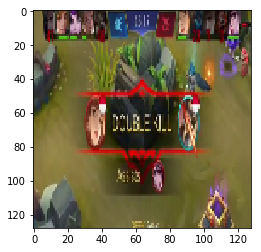

In [128]:
plt.imshow(X_train[3])

In [109]:
# Import test dataset

In [176]:
label_to_id = {v : k for k, v in enumerate(np.unique(Y_train))}
id_to_label = {v : k for k, v in label_to_id.items()}

id_to_label

{0: 'double_kill', 1: 'first_blood', 2: 'none', 3: 'triple_kill', 4: 'wipe'}

In [178]:
Y_train_id = np.array([label_to_id[i] for i in Y_train])
Y_valid_id = np.array([label_to_id[i] for i in Y_valid])
# test_label_id = np.array([label_to_id[i] for i in test_label])
# test_label_id
Y_train_id

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [161]:
Y_train_id.shape

(1094,)

Text(0.5,1,'Historgram of each class label in train dataset')

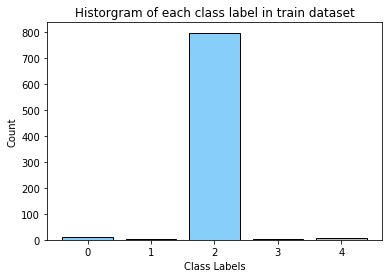

In [179]:
y = np.bincount(Y_train_id)
ii = np.nonzero(y)[0]
plt.bar(np.unique(Y_train_id), y[ii], color="#87CEFA", edgecolor="Black")
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Historgram of each class label in train dataset')

Text(0.5,1,'Historgram of each class label in validation dataset')

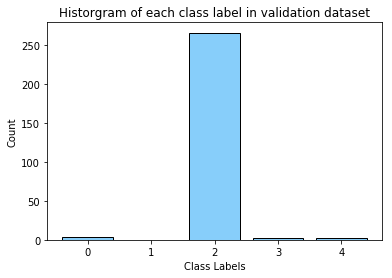

In [180]:
y = np.bincount(Y_valid_id)
ii = np.nonzero(y)[0]
plt.bar(np.unique(Y_valid_id), y[ii], color="#87CEFA", edgecolor="Black")
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Historgram of each class label in validation dataset')

In [181]:
# convert the labels from integers to vectors
Y_train_id = to_categorical(Y_train_id)
Y_valid_id = to_categorical(Y_valid_id)
Y_train_id

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [204]:
y_integers = np.argmax(Y_train_id, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
class_weights = class_weights/np.sum(class_weights)
d_class_weights = dict(enumerate(class_weights))
sample_weights = class_weight.compute_sample_weight('balanced', y_integers)
sample_weights = sample_weights/np.sum(sample_weights)

y_valid_integers = np.argmax(Y_valid_id, axis=1)
sample_weights_valid = class_weight.compute_sample_weight('balanced', y_valid_integers)
sample_weights_valid = sample_weights_valid/np.sum(sample_weights_valid)

d_class_weights
# sample_weights

{0: 0.0901133483459433,
 1: 0.49562341590268816,
 2: 0.001243722499128452,
 3: 0.24781170795134408,
 4: 0.16520780530089604}

In [206]:
Y_train_id.shape[1]

5

In [207]:
# # Runtime data augmentation
# def get_train_test_augmented(X_data=X_train, Y_data=Y_train, validation_split=0.25, batch_size=32, seed=seed):
#     X_train, X_test, Y_train, Y_test = train_test_split(X_data,
#                                                         Y_data,
#                                                         train_size=1-validation_split,
#                                                         test_size=validation_split,
#                                                         random_state=seed)
    
#     # Image data generator distortion options
#     data_gen_args = dict(rotation_range=45.,
#                          width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          shear_range=0.2,
#                          zoom_range=0.2,
#                          horizontal_flip=True,
#                          vertical_flip=True,
#                          fill_mode='reflect')  #use 'constant'??


#     # Train data, provide the same seed and keyword arguments to the fit and flow methods
#     X_datagen = ImageDataGenerator(**data_gen_args)
#     Y_datagen = ImageDataGenerator(**data_gen_args)
#     X_datagen.fit(X_train, augment=True, seed=seed)
#     Y_datagen.fit(Y_train, augment=True, seed=seed)
#     X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
#     Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
#     # Test data, no data augmentation, but we create a generator anyway
#     X_datagen_val = ImageDataGenerator()
#     Y_datagen_val = ImageDataGenerator()
#     X_datagen_val.fit(X_test, augment=True, seed=seed)
#     Y_datagen_val.fit(Y_test, augment=True, seed=seed)
#     X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
#     Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
#     # combine generators into one which yields image and masks
#     train_generator = zip(X_train_augmented, Y_train_augmented)
#     test_generator = zip(X_test_augmented, Y_test_augmented)
    
#     return train_generator, test_generator

In [208]:
# Runtime custom callbacks
#%% https://github.com/deepsense-ai/intel-ai-webinar-neural-networks/blob/master/live_loss_plot.py
# Fixed code to enable non-flat loss plots on keras model.fit_generator()
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from IPython.display import clear_output
#from matplotlib.ticker import FormatStrFormatter

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "categorical_crossentropy"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)
            
            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center left')
        
        plt.tight_layout()
        plt.show();

        try:
            #ix = random.randint(0, len(preds_train_t))
            ix = random.randint(0, int(process_X_train.shape[0]*0.9))
            #ix = 10
            plt.figure(figsize=(16, 4))
            plt.subplot(1, 6, 1)
            plt.title('Raw Image')
            plt.xlabel('id: {}'.format(ix))
            skimage.io.imshow(X_train[ix])
            #plt.show()
            plt.subplot(1, 6, 2)
            plt.title('True Mask')
            plt.xlabel('id: {}'.format(ix))
            skimage.io.imshow(np.squeeze(Y_train[ix]))
            #plt.show()

            plt.subplot(1, 6, 3)
            plt.title('Model Input')
            plt.xlabel('id: {}'.format(ix))
            skimage.io.imshow(np.squeeze(process_X_train[ix]))

            y_label = Y_train[ix][:,:,:]
            y_label = y_label.reshape(1,y_label.shape[0],y_label.shape[1],1)
            weight_mask_tensor = weight_matrix(y_label, epsilon=0.5, filter_size=15) # filter_size=15
            weight_mask = tf.Session().run(weight_mask_tensor)
            weight_mask = weight_mask.reshape(weight_mask.shape[1],weight_mask.shape[1])
            #skimage.io.imshow(weight_mask)
            #plt.show()
            plt.subplot(1, 6, 4)
            plt.title('Weight Mask')
            plt.xlabel('id: {}'.format(ix))
            plt.imshow(weight_mask, cmap='jet') #cmap='hot'
            #plt.colorbar()

            preds_train = model.predict(process_X_train[ix].reshape(1,process_X_train[ix].shape[0],process_X_train[ix].shape[1],process_X_train[ix].shape[2]), verbose=1)
            plt.subplot(1, 6, 5)
            plt.title('Model Output')
            plt.xlabel('id: {}'.format(ix))
            skimage.io.imshow(np.squeeze(preds_train), cmap='gray')

            preds_train_t = (preds_train > 0.5).astype(np.uint8)
            plt.subplot(1, 6, 6)
            plt.title('Predicted Mask 0.5 Threshold')
            plt.xlabel('id: {}'.format(ix))
            skimage.io.imshow(np.squeeze(preds_train_t), cmap='gray')

            plt.tight_layout()
            plt.show()
        except:
            pass
        
plot_losses = PlotLosses(figsize=(16, 4))

In [252]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), input_shape = (img_height, img_width, 3), padding = "same", activation = "relu"))
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), padding = "same", activation = "relu"))
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(keras.layers.Conv2D(32, (3, 3), padding = "same", activation = "relu"))
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(keras.layers.Conv2D(32, (3, 3), padding = "same", activation = "relu"))
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation = "relu"))
model.add(keras.layers.Dense(Y_train_id.shape[1], activation = "softmax"))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 16, 16, 32)        9248      
__________

In [289]:
# Save the model after every epoch
checkpoint = ModelCheckpoint('highlight_model.{epoch:02d}-{loss:.5f}-{val_loss:.5f}.h5',  # model filename
                             monitor='val_loss', 
                             verbose=0, 
                             save_best_only= True, 
                             mode='auto')

reducelr = ReduceLROnPlateau(monitor='val_loss', 
                             factor=0.1, 
                             patience=10, 
                             verbose=0, 
                             mode='auto', 
                             min_delta=1.0e-5, 
                             cooldown=0, 
                             min_lr=0)

adadelta = optimizers.Adadelta(lr=0.4, rho=0.95, epsilon=None, decay=0.01)

model.compile(loss='categorical_crossentropy', optimizer=adadelta, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# model.compile(loss = "categorical_crossentropy", optimizer = keras.optimizers.Adamax(), metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 16, 16, 32)        9248      
__________

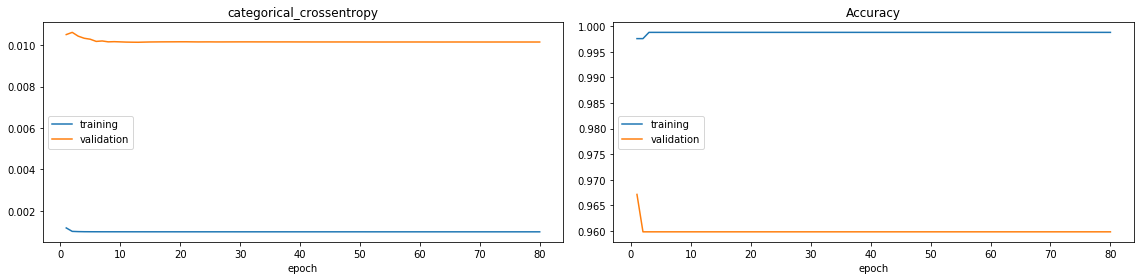

In [290]:
# results = model.fit(X_train, Y_train_id, validation_split=0.1, batch_size=8, epochs=80, callbacks=[plot_losses])#, sample_weight=sample_weights)
# results = model.fit(X_train, Y_train_id, validation_split=0.1, batch_size=8, epochs=80, callbacks=[plot_losses], sample_weight=sample_weights)

results = model.fit(X_train, Y_train_id, validation_data=(X_valid, Y_valid_id, sample_weights_valid), batch_size=8, epochs=80, callbacks=[plot_losses], sample_weight=sample_weights)

In [ ]:
# timestr = time.strftime("%Y%m%d-%H%M%S")
# if not os.path.exists(timestr+'/'):
#     os.makedirs(timestr+'/')

# # change directory to the created folder
# os.chdir(timestr+'/')
    
# # fit network
# history = model.fit(train_X, y_train, epochs=125, batch_size=210, validation_data=(test_X, y_test), 
#                     #callbacks=[checkpoint,TestCallback((test_X, y_test))], verbose=2, shuffle=False)
#                     callbacks=[checkpoint,reducelr,TestCallback((test_X, y_test))], verbose=2, shuffle=False)


# # # save history score
# # with open('trainHistoryDict', 'wb') as file_pi:
# #     pickle.dump(history.history, file_pi)

# # change back the directory
# os.chdir("../")

In [211]:
# Plot history for accuracy and loss
def plot_model(model_details):
    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_details.history['acc'])+1),model_details.history['acc'])
    axs[0].plot(range(1,len(model_details.history['val_acc'])+1),model_details.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_details.history['acc'])+1),len(model_details.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    # Show the plot
    plt.show()

# Plot confusion matrix of prediction value
def plot_confusion_matrix(cm, classes):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def visualize_errors(test_X, labels_test, class_names, labels_pred, correct):
    incorrect = (correct == False)
    
#     # transpose for neupy format
#     images_test *= std
#     images_test += mean

#     images_test = np.transpose(images_test, (0, 2, 3, 1))
    
    # Images of the test-set that have been incorrectly classified.
    images_error = test_X[incorrect]
    print(images_error.shape)
    
    # Get predicted classes for those images
    labels_error = labels_pred[incorrect]
    
    # Print the unique misclassified classes
    print(np.unique(labels_error))
    print([id_to_label[i] for i in np.unique(labels_error)])

    # Get true classes for those images
    labels_true = labels_test[incorrect]
    
    
#     # Plot the first 9 images.
#     plot_images(images=images_error[0:9],
#                 labels_true=labels_true[0:9],
#                 class_names=class_names,
#                 labels_pred=labels_error[0:9])

    return images_error, labels_true

In [291]:
Y_pred =  model.predict(X_train).argmax(axis=1)
Y_test_labels = np.asarray(Y_train_id.argmax(axis=1)).reshape(len(Y_train_id))

print(metrics.classification_report(Y_test_labels, Y_pred))
score = metrics.accuracy_score(Y_test_labels, Y_pred)
print("Train accuracy: {:.2%}".format(score))

correct = (Y_pred == Y_test_labels)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        11
          1       1.00      1.00      1.00         2
          2       1.00      1.00      1.00       797
          3       1.00      0.75      0.86         4
          4       1.00      1.00      1.00         6

avg / total       1.00      1.00      1.00       820

Train accuracy: 99.88%


[[ 11   0   0   0   0]
 [  0   2   0   0   0]
 [  0   0 797   1   0]
 [  0   0   0   3   0]
 [  0   0   0   0   6]]
Normalized confusion matrix


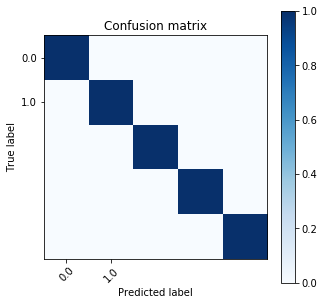

In [292]:
cnf_matrix = metrics.confusion_matrix(Y_pred, Y_test_labels)
print(cnf_matrix)

# Plot confusion matrix
plt.figure(figsize=(5,5)) 
plot_confusion_matrix(cnf_matrix, classes=np.unique(Y_train_id))

In [293]:
Y_pred =  model.predict(X_valid).argmax(axis=1)
Y_test_labels = np.asarray(Y_valid_id.argmax(axis=1)).reshape(len(Y_valid_id))

print(metrics.classification_report(Y_test_labels, Y_pred))
score = metrics.accuracy_score(Y_test_labels, Y_pred)
print("Validation accuracy: {:.2%}".format(score))

correct = (Y_pred == Y_test_labels)

             precision    recall  f1-score   support

          0       0.18      0.50      0.27         4
          2       0.99      0.97      0.98       266
          3       1.00      0.50      0.67         2
          4       1.00      1.00      1.00         2

avg / total       0.98      0.96      0.97       274

Validation accuracy: 95.99%


[[  2   8   1   0]
 [  2 258   0   0]
 [  0   0   1   0]
 [  0   0   0   2]]
Normalized confusion matrix


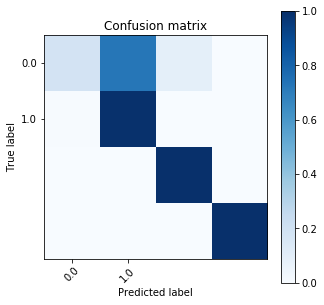

In [294]:
cnf_matrix = metrics.confusion_matrix(Y_pred, Y_test_labels)
print(cnf_matrix)

# Plot confusion matrix
plt.figure(figsize=(5,5)) 
plot_confusion_matrix(cnf_matrix, classes=np.unique(Y_valid_id))

In [295]:
test_error, test_error_label = visualize_errors(X_valid, Y_test_labels, np.unique(Y_train), Y_pred, correct)

(11, 128, 128, 3)
[0 2]
['double_kill', 'none']


In [296]:
test_error_label

array([2, 2, 2, 2, 2, 0, 3, 0, 2, 2, 2], dtype=int64)

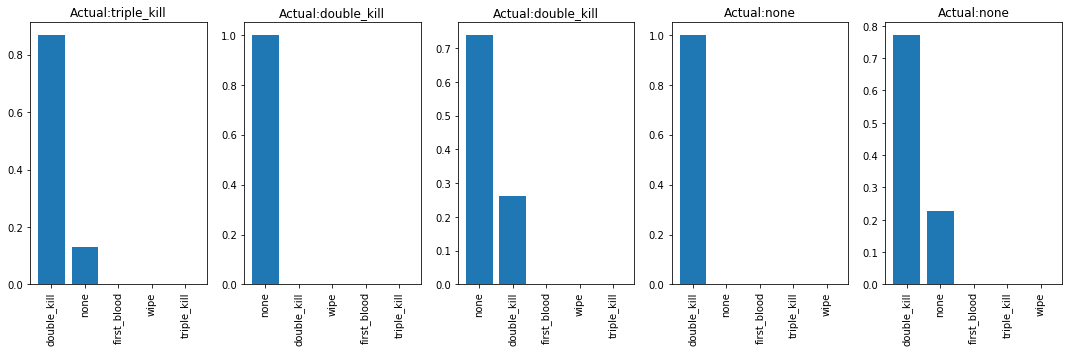

In [297]:
# Random show some sample erros

display = min(5, test_error.shape[0]) # if less than 5
top_class = 5

idx = np.random.choice(len(test_error), display, replace=False)
testing = test_error[idx]
#true_label = np.squeeze(np.asarray(y_test))[idx] # convert matrix to array
true_label = test_error_label[idx]

p = model.predict(testing)

plt.figure(figsize=(15,display))
for i in range(len(idx)):
    
#     plt.subplot(display,2,2*i+1)
#     #plt.tight_layout()
#     plt.bar(range(2),[l for l in true_label[i]])
#     #plt.xticks(range(2), [l for l in true_label[i]])
#     plt.xticks(range(2), [id_to_label[l] for l in id_to_label])
#     plt.title('Actual Label')

    
    
    pred_label = np.argsort(-p[i])[:top_class]
    pred_prob = [p[i][l] for l in pred_label]
    pred_label = [id_to_label[l] for l in pred_label]
    
    #plt.subplot(display,1,j,figsize=(15,5))
    #plt.subplot(display,2,2*i+2)

    plt.subplot(1,top_class,i+1)

#     plt.tight_layout()
    plt.bar(range(top_class),pred_prob)
    plt.xticks(range(top_class), pred_label)
    plt.xticks(rotation=90)
    plt.title('Actual:{}'.format((id_to_label[true_label[i]])))
    
    #plt.show()
    
#     plt.show()
# plt.subplots_adjust(top=1,bottom=-5,left=-0.05,right=1.05)
plt.tight_layout()
plt.show()

In [298]:
id_to_label

{0: 'double_kill', 1: 'first_blood', 2: 'none', 3: 'triple_kill', 4: 'wipe'}

In [309]:
def find_idx(Y_pred, target):
    target_idx = []
    for i in range(len(Y_pred)):
        if Y_pred[i]==target:
            target_idx.append(i)
    return target_idx

Y_pred =  model.predict(X_valid).argmax(axis=1)
find_idx(Y_pred, 4)

[27, 31]

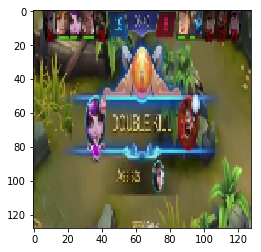

In [284]:
plt.imshow(X_valid[226])

In [308]:
model.save("highlight_model.h5")

# # # load model
# model = load_model('highlight_model.h5')

In [307]:
# import pickle 

# pkl_filename = "highlight_model.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)


In [ ]:
results = model.fitgenerator(X_train, Y_train_id, validation_split=0.1, batch_size=8, epochs=150, callbacks=[plot_losses], sample_weight=sample_weights)

In [ ]:
# model.fit_generator(get_train_test_augmented(X_data=X_train, Y_data=Y_train_id), samples_per_epoch = 60000, nb_epoch = 2, verbose=2, show_accuracy=True, callbacks=[plot_losses], validation_data=None, class_weight=None)

In [140]:
Y_pred = model.predict(X_train)
Y_pred

array([[1.00000000e+00, 3.40923609e-11, 2.87797430e-08, 2.96634829e-34,
        1.33032941e-31],
       [1.00000000e+00, 5.49895773e-09, 2.92274951e-08, 3.42589820e-33,
        1.08997930e-30],
       [1.00000000e+00, 7.01520116e-20, 9.29527921e-09, 1.61168448e-37,
        2.63194017e-35],
       ...,
       [1.30735512e-21, 3.41807822e-26, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.06100605e-26, 2.11638636e-30, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [3.83219193e-23, 1.33771236e-25, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00]], dtype=float32)

In [ ]:
# class weight for class balancing

In [91]:
model.fit(X_train, Y_train_id, batch_size = 128, epochs = 100)

Epoch 1/100
4/4 [==============================] - 1s 165ms/step - loss: 8.6439 - acc: 0.2500
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 12.0886 - acc: 0.2500
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 12.0886 - acc: 0.2500
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 12.0886 - acc: 0.2500
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 12.0886 - acc: 0.2500
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 12.0886 - acc: 0.2500
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 12.0886 - acc: 0.2500
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 12.0886 - acc: 0.2500
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 12.0886 - acc: 0.2500
Epoch 10/100
4/4 [==============================] - 0s 6ms/step - loss: 12.0886 - acc: 0.2500
Epoch 11/100
4/4 [==============================] - 0s 5ms/step - lo

Epoch 89/100
4/4 [==============================] - 0s 5ms/step - loss: 12.0886 - acc: 0.2500
Epoch 90/100
4/4 [==============================] - 0s 4ms/step - loss: 12.0886 - acc: 0.2500
Epoch 91/100
4/4 [==============================] - 0s 4ms/step - loss: 12.0886 - acc: 0.2500
Epoch 92/100
4/4 [==============================] - 0s 4ms/step - loss: 12.0886 - acc: 0.2500
Epoch 93/100
4/4 [==============================] - 0s 5ms/step - loss: 12.0886 - acc: 0.2500
Epoch 94/100
4/4 [==============================] - 0s 5ms/step - loss: 12.0886 - acc: 0.2500
Epoch 95/100
4/4 [==============================] - 0s 4ms/step - loss: 12.0886 - acc: 0.2500
Epoch 96/100
4/4 [==============================] - 0s 5ms/step - loss: 12.0886 - acc: 0.2500
Epoch 97/100
4/4 [==============================] - 0s 5ms/step - loss: 12.0886 - acc: 0.2500
Epoch 98/100
4/4 [==============================] - 0s 5ms/step - loss: 12.0886 - acc: 0.2500
Epoch 99/100
4/4 [==============================] - 0s 5ms/s